# DIFFUSION MODEL (DDPM) IMPLEMENTATION:

This Diffusion Model Code is inspired from here: https://huggingface.co/blog/annotated-diffusion 
> This Notebook is inspired from the HuggingFace Blog Article on Diffusion Models. Implemented a similar architecture for AnimeFaces Dataset Problem.

Modified/Added the following to the above code:
* Modified the Model Architecture & Implementation for AnimeFacesDataset Dataset
* Added Custom Data Processing for AnimeFacesDataset (Original Model was for FashionMNIST Torch Dataset).
* Added Custom Image saving Module (with un-normalization) to save the generated Fake images back as Image files & visualize.
* Added Code to Save & Load Models to avoid re-training, along with a test to see if the model is loaded correctly.
* Added Code to Load Model to continue Training from last checkpoint & to save Model every 50 Iterations.
* Added Code to generate Large Set of Non-reproducible Images, along with reproducible Images for every Model iteration.
* Added Code to compute our evaluation metrics to get the Model performance from the processed images of the input data and the generated fake images.


In [6]:
# Connect Drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Clear Cache if CUDA Memory Full (Intermittent Run)
# torch.cuda.empty_cache()

In [3]:
# PATH VARIABLES (Dataset, Dataset & Results Paths)

google_colab = True

root_folder = 'drive/MyDrive/' if google_colab else '/Users/venkateshgunda/Documents/ASU_MSCS/CSE598_IDL/Group_Project/Code/'
root_dataset_path=root_folder+('Colab Datasets/AnimeFacesDataset/' if google_colab else 'Data/')
raw_dataset_path=root_dataset_path+'Raw/'
processed_dataset_path=root_dataset_path+'Processed/'
processed_subset_dataset_path=root_dataset_path+'Processed_15KSubset/'
model_root_path = root_folder+('Colab Models/CSE598_GroupProject_DiffusionModel/' if google_colab else 'Models/')
results_path = root_folder + ('Colab Results/CSE598_GroupProject/DiffusionModel/' if google_colab else 'Results/')

max_label_length=30
print('Root Directory'.ljust(max_label_length),root_folder)
print('Dataset Root:'.ljust(max_label_length),root_dataset_path)
print('Dataset Raw:'.ljust(max_label_length),raw_dataset_path)
print('Dataset Processed:'.ljust(max_label_length),processed_dataset_path)
print('Dataset Processed (Subset):'.ljust(max_label_length),processed_subset_dataset_path)
print('Model Root Directory:'.ljust(max_label_length),model_root_path)
print('Results Path:'.ljust(max_label_length),results_path)

# Confirm Paths are Fine before Processing
file_paths_ok = input('Are these Paths right? (Y/N): ').strip().lower()[0]
assert file_paths_ok == 'y'

# Create if Models & Results Folders are missing
import os
if not os.path.isdir(model_root_path):
  os.makedirs(model_root_path)
if not os.path.isdir(results_path):
  os.makedirs(results_path)

Root Directory                 drive/MyDrive/
Dataset Root:                  drive/MyDrive/Colab Datasets/AnimeFacesDataset/
Dataset Raw:                   drive/MyDrive/Colab Datasets/AnimeFacesDataset/Raw/
Dataset Processed:             drive/MyDrive/Colab Datasets/AnimeFacesDataset/Processed/
Dataset Processed (Subset):    drive/MyDrive/Colab Datasets/AnimeFacesDataset/Processed_15KSubset/
Model Root Directory:          drive/MyDrive/Colab Models/CSE598_GroupProject_DiffusionModel/
Results Path:                  drive/MyDrive/Colab Results/CSE598_GroupProject/DiffusionModel/
Are these Paths right? (Y/N): y


In [7]:
!pip install -q -U einops datasets matplotlib tqdm
!pip install matplotlib==3.1.3

     |████████████████████████████████| 41 kB 449 kB/s 
     |████████████████████████████████| 451 kB 27.5 MB/s 
     |████████████████████████████████| 9.4 MB 63.7 MB/s 
     |████████████████████████████████| 182 kB 97.0 MB/s 
     |████████████████████████████████| 132 kB 104.6 MB/s 
     |████████████████████████████████| 212 kB 101.3 MB/s 
     |████████████████████████████████| 127 kB 102.6 MB/s 
     |████████████████████████████████| 965 kB 75.5 MB/s 
     |████████████████████████████████| 295 kB 97.4 MB/s 


In [8]:
import math
from inspect import isfunction
from functools import partial

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F

from PIL import Image
import requests

## DIFFUSION MODEL DEFINITION

In [9]:
# Utility Functions for Diffusion Model Network


def exists(x):
  return x is not None

def default(val, d):
  if exists(val):
    return val
  return d() if isfunction(d) else d

class Residual(nn.Module):
  def __init__(self, fn):
    super().__init__()
    self.fn = fn
  def forward(self, x, *args, **kwargs):
    return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
  return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
  return nn.Conv2d(dim, dim, 4, 2, 1)

In [10]:
# Sinusoidal Position Embeddings


class SinusoidalPositionEmbeddings(nn.Module):
  def __init__(self, dim):
    super().__init__()
    self.dim = dim
  def forward(self, time):
    device = time.device
    half_dim = self.dim // 2
    embeddings = math.log(10000) / (half_dim-1)
    embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
    embeddings = time[:, None] * embeddings[None, :]
    embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
    return embeddings

In [11]:
# ResNet/ConvNext Block


class Block(nn.Module):
  def __init__(self, dim, dim_out, groups=8):
    super().__init__()
    self.proj = nn.Conv2d(dim, dim_out, 3, padding=1)
    self.norm = nn.GroupNorm(groups, dim_out)
    self.act = nn.SiLU()
  def forward(self, x, scale_shift=None):
    x=self.proj(x)
    x=self.norm(x)
    if exists(scale_shift):
      scale, shift = scale_shift
      x=x*(scale+1)+shift
    x=self.act(x)
    return x

class ResnetBlock(nn.Module):
  def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
    super().__init__()
    self.mlp = (
        nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
        if exists(time_emb_dim)
        else None
    )
    self.block1 = Block(dim, dim_out, groups=groups)
    self.block2 = Block(dim_out, dim_out, groups=groups)
    self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim!=dim_out else nn.Identity()
  def forward(self, x, time_emb=None):
    h=self.block1(x)
    if exists(self.mlp) and exists(time_emb):
      time_emb=self.mlp(time_emb)
      h=rearrange(time_emb, "b c -> b c 1 1")+h
    h=self.block2(h)
    return h+self.res_conv(x)

class ConvNextBlock(nn.Module):
  def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
    super().__init__()
    self.mlp = (
        nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
        if exists(time_emb_dim)
        else None
    )
    self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)
    self.net = nn.Sequential(
        nn.GroupNorm(1,dim) if norm else nn.Identity(),
        nn.Conv2d(dim, dim_out*mult, 3, padding=1),
        nn.GELU(),
        nn.GroupNorm(1, dim_out * mult),
        nn.Conv2d(dim_out * mult, dim_out, 3, padding=1)
    )
    self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim!=dim_out else nn.Identity()
  def forward(self, x, time_emb=None):
    h=self.ds_conv(x)
    if exists(self.mlp) and exists(time_emb):
      condition=self.mlp(time_emb)
      h=h+rearrange(condition,"b c -> b c 1 1")
    h=self.net(h)
    # print(h.shape,self.res_conv(x).shape)
    return h+self.res_conv(x)

In [12]:
# Attention Module


class Attention(nn.Module):
  def __init__(self, dim, heads=4, dim_head=32):
    super().__init__()
    self.scale=dim_head**(-0.5)
    self.heads=heads
    hidden_dim=dim_head*heads
    self.to_qkv=nn.Conv2d(dim, hidden_dim*3, 1, bias=False)
    self.to_out=nn.Conv2d(hidden_dim, dim, 1)
  def forward(self, x):
    b, c, h, w = x.shape
    qkv = self.to_qkv(x).chunk(3, dim=1)
    q, k, v = map(
        lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
    )
    q=q*self.scale
    ##############
    sim=einsum("b h d i, b h d j -> b h i j", q, k)
    sim=sim-sim.amax(dim=-1,keepdim=True).detach()
    ##############
    attn=sim.softmax(dim=-1)
    out=einsum("b h i j, b h d j -> b h i d", attn, v)
    out=rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
    return self.to_out(out)

class LinearAttention(nn.Module):
  def __init__(self, dim, heads=4, dim_head=32):
    super().__init__()
    self.scale=dim_head**(-0.5)
    self.heads=heads
    hidden_dim=dim_head*heads
    self.to_qkv=nn.Conv2d(dim, hidden_dim*3, 1, bias=False)
    self.to_out=nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), nn.GroupNorm(1, dim))
  def forward(self, x):
    b, c, h, w = x.shape
    qkv = self.to_qkv(x).chunk(3, dim=1)
    q, k, v = map(
        lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
    )
    q=q.softmax(dim=-2)
    k=k.softmax(dim=-1)
    q=q*self.scale
    context=torch.einsum("b h d n, b h e n -> b h d e", k, v)
    out=torch.einsum("b h d e, b h d n -> b h e n", context, q)
    out=rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
    return self.to_out(out)

In [13]:
# Group Normalization


class PreNorm(nn.Module):
  def __init__(self, dim, fn):
    super().__init__()
    self.fn=fn
    self.norm=nn.GroupNorm(1,dim)
  def forward(self,x):
    x=self.norm(x)
    return self.fn(x)

In [14]:
# Conditional U-Net


class Unet(nn.Module):
  def __init__(self,dim,init_dim=None,out_dim=None,dim_mults=(1,2,4,8),channels=3,with_time_emb=True,resnet_block_groups=8,use_convnext=True,convnext_mult=2):
    super().__init__()
    self.channels=channels
    init_dim=default(init_dim,dim//3*2)
    self.init_conv=nn.Conv2d(channels,init_dim,7,padding=3)
    dims=[init_dim,*map(lambda m: dim*m, dim_mults)]
    in_out=list(zip(dims[:-1], dims[1:]))
    if use_convnext:
      block_klass=partial(ConvNextBlock, mult=convnext_mult)
    else:
      block_klass=partial(ResnetBlock, groups=resnet_block_groups)
    if with_time_emb:
      time_dim = dim*4
      self.time_mlp = nn.Sequential(
          SinusoidalPositionEmbeddings(dim),
          nn.Linear(dim, time_dim),
          nn.GELU(),
          nn.Linear(time_dim, time_dim)
      )
    else:
      time_dim=None
      self.time_mlp=None
    self.downs=nn.ModuleList([])
    self.ups=nn.ModuleList([])
    num_resolutions=len(in_out)
    for ind, (dim_in, dim_out) in enumerate(in_out):
      is_last = ind >= (num_resolutions-1)
      self.downs.append(
          nn.ModuleList(
              [
                block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                Downsample(dim_out) if not is_last else nn.Identity()
              ]
          )
      )
    mid_dim=dims[-1]
    self.mid_block1=block_klass(mid_dim,mid_dim,time_emb_dim=time_dim)
    self.mid_attn=Residual(PreNorm(mid_dim,Attention(mid_dim)))
    self.mid_block2=block_klass(mid_dim,mid_dim,time_emb_dim=time_dim)
    for ind, (dim_in,dim_out) in enumerate(reversed(in_out[1:])):
      is_last=ind>=(num_resolutions-1)
      self.ups.append(
          nn.ModuleList(
              [
                  block_klass(dim_out*2,dim_in,time_emb_dim=time_dim),
                  block_klass(dim_in,dim_in,time_emb_dim=time_dim),
                  Residual(PreNorm(dim_in,LinearAttention(dim_in))),
                  Upsample(dim_in) if not is_last else nn.Identity()
              ]
          )
      )
    out_dim=default(out_dim,channels)
    self.final_conv=nn.Sequential(block_klass(dim,dim),nn.Conv2d(dim,out_dim,1))
  def forward(self,x,time):
    x=self.init_conv(x)
    t=self.time_mlp(time) if exists(self.time_mlp) else None
    h=[]
    for block1,block2,attn,downsample in self.downs:
      x=block1(x,t)
      x=block2(x,t)
      x=attn(x)
      h.append(x)
      x=downsample(x)
    x=self.mid_block1(x,t)
    x=self.mid_attn(x)
    x=self.mid_block2(x,t)
    for block1,block2,attn,upsample in self.ups:
      x=torch.cat((x,h.pop()),dim=1)
      x=block1(x,t)
      x=block2(x,t)
      x=attn(x)
      x=upsample(x)
    return self.final_conv(x)


In [15]:
# Forward Diffusion Process


def cosine_beta_scheduler(timesteps, s=0.008):
  steps=timesteps+1
  x=torch.linspace(0,timesteps,steps)
  alphas_cumprod = torch.cos(((x/timesteps)+s)/(1+s) * torch.pi * 0.5) ** 2
  alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
  betas=1-(alphas_cumprod[1:]/alphas_cumprod[:-1])
  return torch.clip(betas,0.0001,0.9999)

def linear_beta_scheduler(timesteps):
  beta_start=0.0001
  beta_end=0.02
  return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
  beta_start=0.0001
  beta_end=0.02
  return torch.linspace(beta_start**0.5,beta_end**0.5,timesteps)**2

def sigmoid_beta_schedule(timesteps):
  beta_start=0.0001
  beta_end=0.02
  betas=torch.linspace(-6,6,timesteps)
  return torch.sigmoid(betas)*(beta_end-beta_start)+beta_start

## UTILITY FUNCTIONS (for MODEL TRAINING)

In [16]:
# TESTTT


timesteps=200
betas=linear_beta_scheduler(timesteps=timesteps)
alphas=1.0-betas
alphas_cumprod=torch.cumprod(alphas,axis=0)
alphas_cumprod_prev=F.pad(alphas_cumprod[:-1],(1,0), value=1.0)
sqrt_recip_alphas=torch.sqrt(1.0/alphas)

sqrt_alphas_cumprod=torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod=torch.sqrt(1.0-alphas_cumprod)

posterior_variance=betas*(1.0-alphas_cumprod_prev)/(1.0-alphas_cumprod)

def extract(a,t,x_shape):
  batch_size=t.shape[0]
  out=a.gather(-1, t.cpu())
  return out.reshape(batch_size, *((1,)*(len(x_shape)-1))).to(t.device)

In [18]:
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize

image_size = 128
transform = Compose([
    Resize(image_size),
    CenterCrop(image_size),
    ToTensor(), # turn into Numpy array of shape HWC, divide by 255
    Lambda(lambda t: (t * 2) - 1),
    
])

torch.Size([1, 3, 128, 128])

In [19]:
reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2),
     Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     Lambda(lambda t: t * 255.),
     Lambda(lambda t: t.numpy().astype(np.uint8)),
     ToPILImage(),
])

In [21]:
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

In [22]:
def get_noisy_image(x_start, t):
  # add noise
  x_noisy = q_sample(x_start, t=t)

  # turn back into PIL image
  noisy_image = reverse_transform(x_noisy.squeeze())

  return noisy_image

In [25]:
import matplotlib.pyplot as plt

# use seed for reproducability
torch.manual_seed(0)

# source: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [27]:
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

## DATASET PREPARATION & DATALOADER

In [31]:
# Number of workers for dataloader
workers = 2

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Data Normalization Setting
normalize_mean = (0.5, 0.5, 0.5)
normalize_std = (0.5, 0.5, 0.5)

image_size = 64
batch_size = 128
channels = 3

In [32]:
# UnNormalize Class allows us to reverse the data processing, get the original image tensor back to write to a file


class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unorm = UnNormalize(mean=normalize_mean, std=normalize_std)

In [33]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

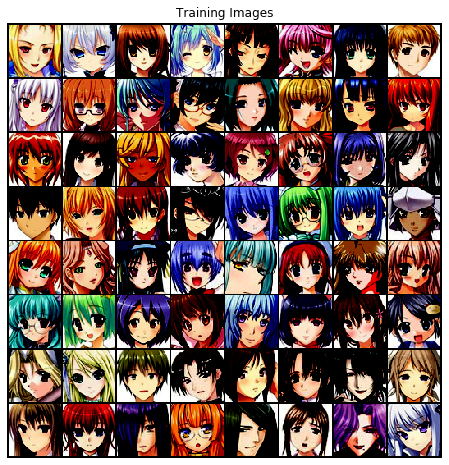

In [ ]:
# Create the dataset [Intermittently fails because of large number of Files. Retry until it succeeds.]


dataroot = processed_dataset_path
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Lambda(lambda t: (t * 2) - 1)
                           ]))

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
# plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=False).cpu(),(1,2,0)))

In [34]:
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

# Algorithm 2 (including returning all images)
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))


## MODEL TRAINING

In [35]:
from pathlib import Path

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 1000 # Never Saves. For 100, it works.

# Save Model every x Iterations
model_save_step = 50

In [ ]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet(
    dim=image_size,
    channels=channels,
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)


In [ ]:
from torchvision.utils import save_image

epochs = 2000

# Continue Training from the Last Checkpoint
pre_computed = 300
model = torch.load(f'{model_root_path}diffusion_model_{pre_computed}.pt')

for epoch in range(epochs):
    print(f"Epoch #{epoch+1}")
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      batch_size = batch[0].shape[0]
      batch = batch[0].to(device)

      # Algorithm 1 line 3: sample t uniformally for every example in the batch
      t = torch.randint(0, timesteps, (batch_size,), device=device).long()

      loss = p_losses(model, batch, t, loss_type="huber")

      if step % 100 == 0:
        print("Loss:", loss.item(),"Step:", step)

      loss.backward()
      optimizer.step()

      # save generated images
      # if step != 0 and step % save_and_sample_every == 0:
      #   image_samples = tuple([torch.from_numpy(sample) for sample in sample(model, image_size=image_size,batch_size=64, channels=channels)[-1]])
      #   all_images = torch.cat(image_samples, dim=0)
      #   all_images = (all_images + 1) * 0.5
      #   save_image(all_images, str(results_folder / f'sample-{epoch}-{step}.jpeg'), nrow = 4)
    
    # Save Model every model_save_step Epochs (Optionally Load)
    if epoch>0 and epoch%model_save_step==0:
      model_save_path = f'{model_root_path}diffusion_model_{epoch+pre_computed}.pt'
      torch.save(model, model_save_path)
      # model = torch.load(model_save_path)


Epoch #1
Loss: 0.028863001614809036 Step: 0
Loss: 0.034414324909448624 Step: 100
Loss: 0.03794547915458679 Step: 200
Loss: 0.033622920513153076 Step: 300
Loss: 0.03161949664354324 Step: 400
Epoch #2
Loss: 0.0324699804186821 Step: 0
Loss: 0.030860191211104393 Step: 100
Loss: 0.02479693293571472 Step: 200
Loss: 0.03763165697455406 Step: 300
Loss: 0.03759609907865524 Step: 400
Epoch #3
Loss: 0.03659537434577942 Step: 0
Loss: 0.03415090590715408 Step: 100
Loss: 0.028780823573470116 Step: 200
Loss: 0.0340508371591568 Step: 300
Loss: 0.037223510444164276 Step: 400
Epoch #4
Loss: 0.0337735190987587 Step: 0
Loss: 0.036791518330574036 Step: 100
Loss: 0.04086587578058243 Step: 200
Loss: 0.03326563537120819 Step: 300
Loss: 0.03182939440011978 Step: 400
Epoch #5
Loss: 0.03674321621656418 Step: 0
Loss: 0.03558562695980072 Step: 100
Loss: 0.03160906583070755 Step: 200
Loss: 0.034220628440380096 Step: 300
Loss: 0.0335041806101799 Step: 400
Epoch #6
Loss: 0.03590456396341324 Step: 0
Loss: 0.0294238533

KeyboardInterrupt: ignored

## MODEL SAVE & LOAD (post MODEL TRAINING)

In [ ]:
# Sample 64 Images

samples = sample(model, image_size=image_size, batch_size=64, channels=channels)

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
# Save Model

model_save_path = f'{model_root_path}diffusion_model_{epoch}.pt'
torch.save(model, model_save_path)

In [91]:
# Load & Eval Model

# epochs = 350
# model_save_path = f'{model_root_path}diffusion_model_{epoch}.pt'
loaded_model = torch.load(model_save_path)
loaded_model.eval()

Unet(
  (init_conv): Conv2d(3, 42, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=64, out_features=256, bias=True)
    (2): GELU(approximate=none)
    (3): Linear(in_features=256, out_features=256, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0): ConvNextBlock(
        (mlp): Sequential(
          (0): GELU(approximate=none)
          (1): Linear(in_features=256, out_features=42, bias=True)
        )
        (ds_conv): Conv2d(42, 42, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=42)
        (net): Sequential(
          (0): GroupNorm(1, 42, eps=1e-05, affine=True)
          (1): Conv2d(42, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): GELU(approximate=none)
          (3): GroupNorm(1, 128, eps=1e-05, affine=True)
          (4): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (res_conv): Conv2d(42

## GENERATE IMAGES (MODEL INFERENCE & VISUALIZATION)

In [93]:
# Generation Lots of Fake Images

# fake_image_multiples=10 # If we want 64*x samples, the value is x for the variable
# torch.random.seed()
# @torch.no_grad()
# def sample(model, image_size, batch_size=16, channels=3):
#     return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))
# for i in range(fake_image_multiples):
#   samples = sample(loaded_model, image_size=image_size, batch_size=512, channels=channels)
#   from torchvision.utils import save_image
#   from pathlib import Path

#   results_folder = Path(f'.{results_path}')

#   import shutil, os

#   results_folder.mkdir(exist_ok = True)

#   # random_index = 53
#   print(samples[-1][0].shape,image_size,channels)
#   # plt.imshow(samples[-1][random_index].reshape(image_size, image_size, channels).squeeze()) #, cmap="gray")

#   # samples_tensor = unorm(torch.Tensor([sample.reshape(image_size, image_size, channels) for sample in samples[-1]]))
#   # print(samples_tensor.shape)

#   existing=len(os.listdir(results_folder))
#   print('Fake Samples:', existing)
#   for j,sample_img in enumerate(samples[-1]):
#     image_tensor = torch.tensor(sample_img)
#     image_tensor = (image_tensor + 1) * 0.5
#     save_image(image_tensor, str(results_folder / f'fake_image_{j+existing}.jpeg'))


# Generate Single Batch of Reproducible Images
samples = sample(loaded_model, image_size=image_size, batch_size=64, channels=channels)

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

(64, 3, 64, 64) (3, 64, 64) 64 3
Fake Samples: 0
200


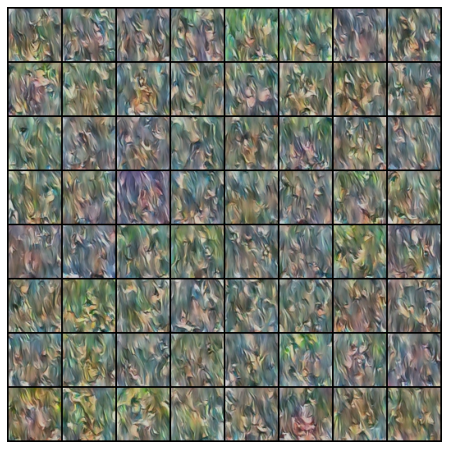

In [94]:
# Store & Visualize Generated Samples


import shutil, os

from torchvision.utils import save_image
from pathlib import Path

results_folder = Path(f'.{results_path}')

# Deletes Existing Results, if exists
if os.path.isdir(results_folder):
  shutil.rmtree(results_folder)
os.makedirs(results_folder)

results_folder.mkdir(exist_ok = True)

# print(samples[-1].shape,samples[-1][0].shape,image_size,channels)

img_list_test = []
for sample in samples:
  image_tensor = torch.tensor(sample)
  image_tensor = (image_tensor + 1) * 0.5
  img_list_test.append(image_tensor)

existing=len(os.listdir(results_folder))
print('Fake Samples:',existing)
for i,sample in enumerate(samples[-1]):
  image_tensor = torch.tensor(sample)
  image_tensor = (image_tensor + 1) * 0.5
  save_image(image_tensor, str(results_folder / f'fake_image_{i+existing}.jpeg'))

img_list_grid = [vutils.make_grid(img, padding=2, normalize=True) for img in img_list_test]
print(len(img_list_grid))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(np.transpose(img_list_grid[-1],(1,2,0)))

## MODEL EVALUATION

In [97]:
# Evaluating Fake & Real Images
!pip install pytorch-fid
# !python -m pytorch_fid "drive/MyDrive/Colab Datasets/AnimeFacesDataset/" "drive/MyDrive/Colab Datasets/AnimeFacesDataset/"
print('\n\nComputing the FID Score for the Model:')
!python -m pytorch_fid 'drive/MyDrive/Colab Datasets/AnimeFacesDataset/Processed_15KSubset/images/' 'drive/MyDrive/Colab Results/CSE598_GroupProject/DiffusionModel/'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Computing the FID Score for the Model:
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100% 300/300 [01:07<00:00,  4.42it/s]
100% 2/2 [00:00<00:00,  4.03it/s]
FID:  336.30334530909306


# EVALUATION SCORES:

## PRELIMINARY MODEL EVALUATION SCORES:
* 20 Epochs: FID: ~331
* 350 Epochs: FID: 280.2657223619516
* 350 Epochs (~2800 samples): 197.5694

## FID FINAL SCORES:
*This Model Evaluation is run on 15,000 Real Samples & 64 Fake Samples*

* 20 Epochs: 336.3033
* 50 Epochs: 272.9371
* 100 Epochs: 264.9171
* 150 Epochs: 283.2173
* 200 Epochs: 273.4671
* 250 Epochs: 277.0063
* 300 Epochs: 287.3084
* 350 Epochs: 272.7530